In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
sns.set(palette="summer",font='Microsoft YaHei',font_scale=1.2)
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
# 获取当前脚本所在的目录
current_working_directory = os.getcwd()
# 构建指向上一级目录中csvjd.csv的绝对路径
file_path = os.path.join(current_working_directory, 'csvjd.csv')
# 规范化路径，处理掉 '..'
file_path = os.path.normpath(file_path)
df = pd.read_csv(file_path,encoding='gbk')

In [11]:
print('数据形状：{}'.format(df.shape))
print('重复值：{}条'.format(df.duplicated().sum()))
print('空值情况：')
print(df.isnull().sum())

数据形状：(5984, 5)
重复值：77条
空值情况：
price       0
name        0
url         0
comment     0
shopname    0
dtype: int64


进行数据清洗，包括删除重复记录和处理评论数据

In [12]:
# 删除重复值
df.drop_duplicates(inplace=True)
print('去重后数据形状：{}'.format(df.shape))

# 处理评论数据：将"万"单位转换为具体数值
def comment_process(x):
    x = x.replace('+', '')
    if '万' in x:
        x = x.replace('万', '')
        x = float(x) * 10000
    return int(x)

df['new_comment'] = df['comment'].apply(comment_process)

去重后数据形状：(5907, 5)


# 店铺类型分类
根据店铺名称的关键词将店铺分为四类：京东自营、旗舰店、专营店和其他。

In [13]:
def shop_grouping(frame):
    new_group = []
    for i in range(len(frame)):
        if '自营' in frame.iloc[i, 4]:  # shopname列
            new_group.append('京东自营')
        elif '旗舰店' in frame.iloc[i, 4]:
            new_group.append('旗舰店')
        elif '专营店' in frame.iloc[i, 4]:
            new_group.append('专营店')
        else:
            new_group.append('其他')
    frame['shop_type'] = new_group

shop_grouping(df)

# 描述性统计分析
## 店铺类型分布

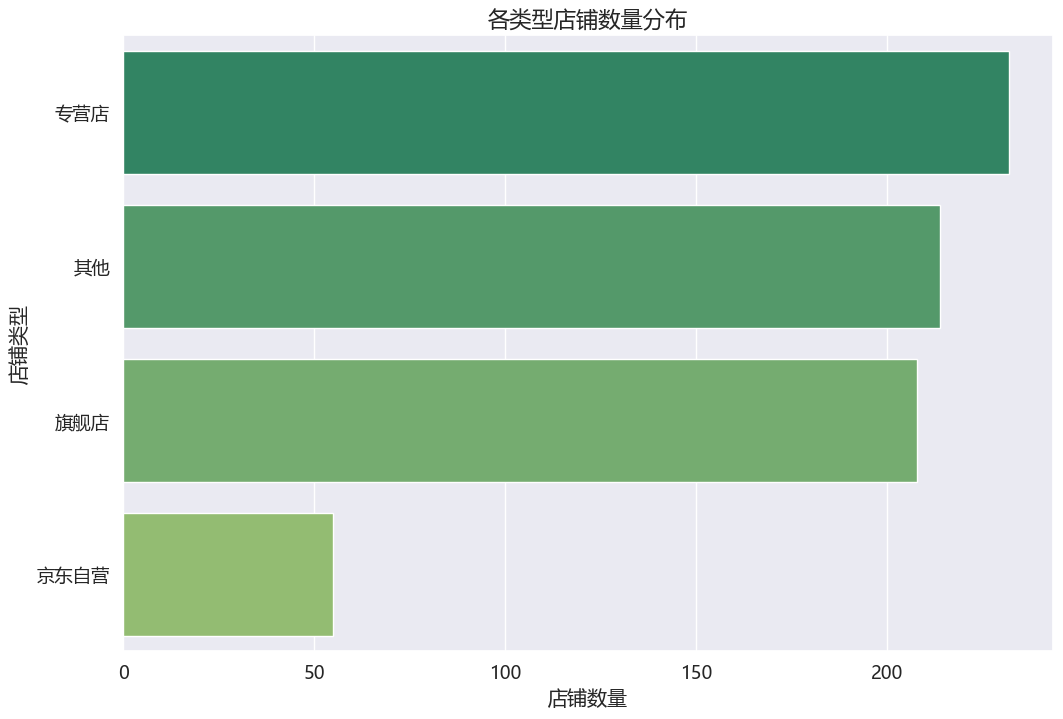

In [16]:
# 统计各类店铺数量
shop_counts = df.groupby('shop_type').shopname.nunique().reset_index(name='counts')
shop_counts = shop_counts.sort_values('counts', ascending=False)

# 可视化店铺数量分布
plt.figure(figsize=(12, 8))
sns.barplot(x='counts', y='shop_type', data=shop_counts)
plt.title('各类型店铺数量分布', fontsize=16)
plt.xlabel('店铺数量')
plt.ylabel('店铺类型')
plt.show()

# 商品数量分布

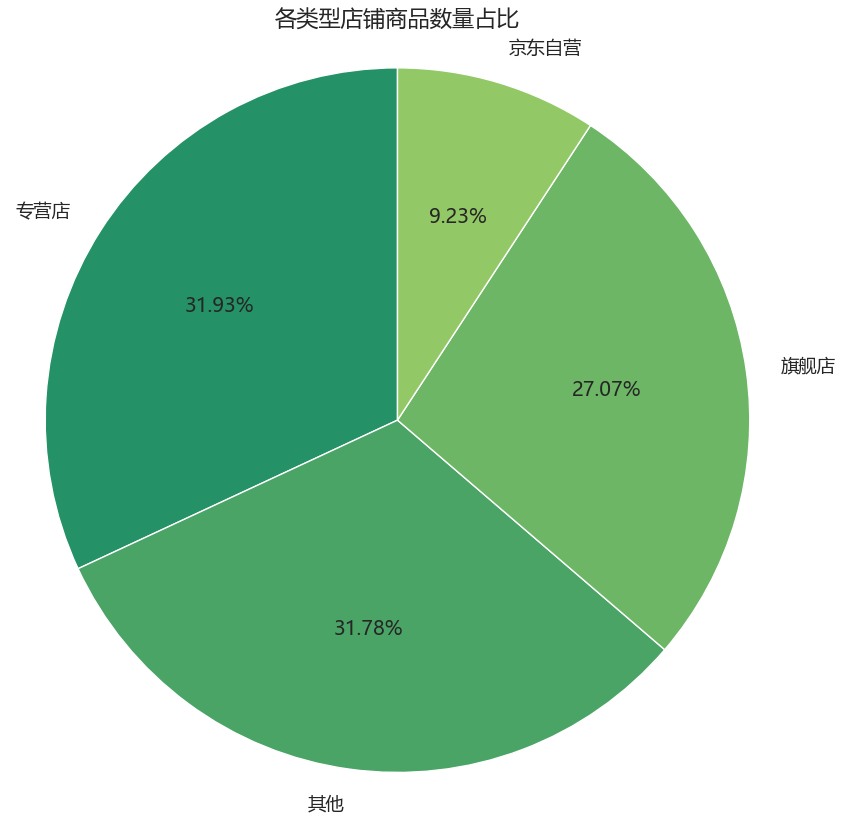

In [17]:
# 商品数量分布
plt.figure(figsize=(10, 10))
size = df['shop_type'].value_counts().values
labels = df['shop_type'].value_counts().index
plt.pie(size, labels=labels, autopct='%.2f%%', startangle=90)
plt.axis('equal')
plt.title('各类型店铺商品数量占比', fontsize=16)
plt.show()

## 价格分析

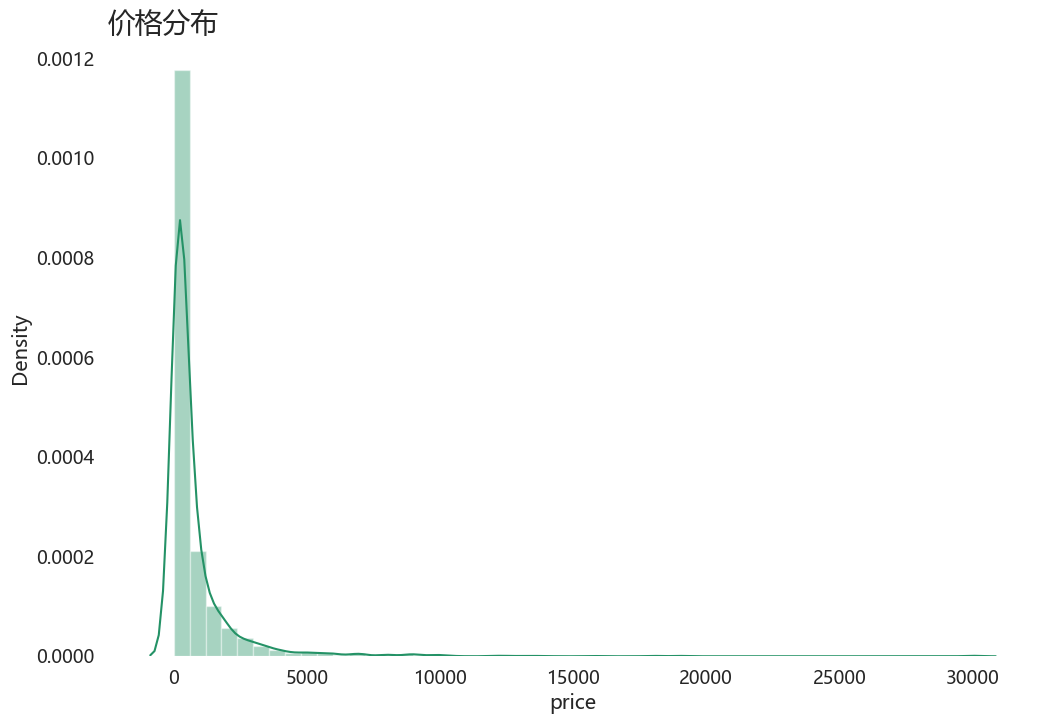

In [20]:
# 价格分布直方图
plt.figure(figsize=(12,8))
sns.distplot(df['price'])
plt.title('价格分布',loc='left',fontsize=20)
plt.box(False)
plt.show()


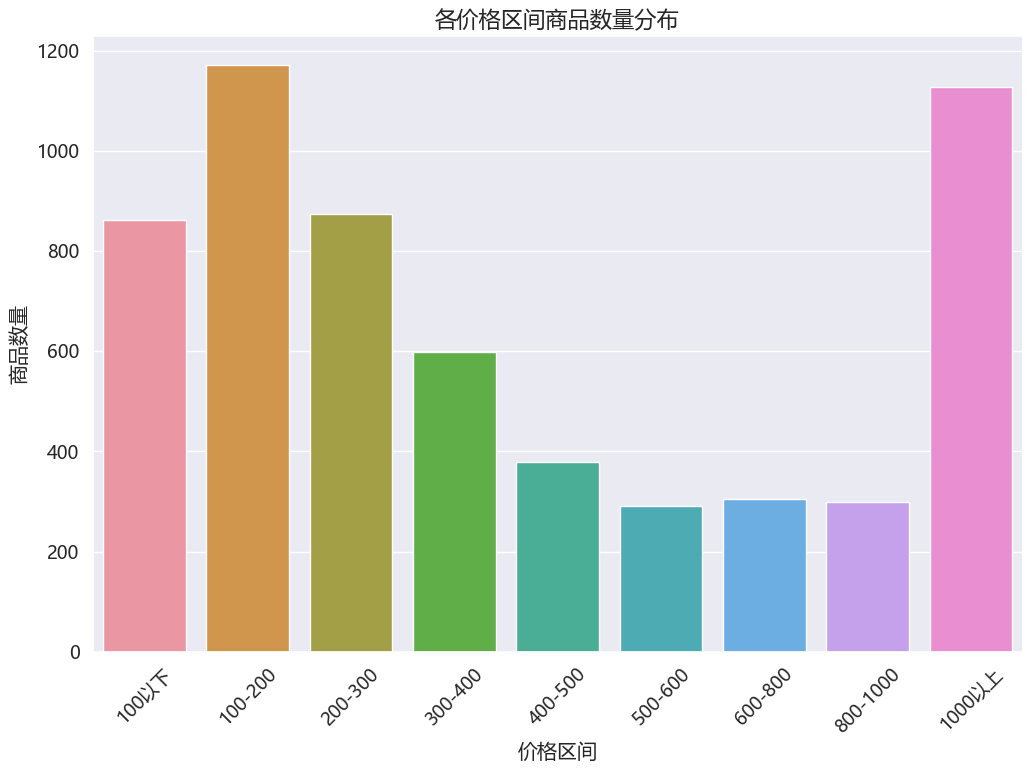

In [21]:
# 创建价格区间
df['price_range'] = pd.cut(x=df['price'], 
                           bins=[0, 100, 200, 300, 400, 500, 600, 800, 1000, 30000],
                           labels=['100以下', '100-200', '200-300', '300-400', '400-500', 
                                  '500-600', '600-800', '800-1000', '1000以上'])

# 各价格区间商品数量分布
price_dist = df['price_range'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(x=price_dist.index, y=price_dist.values)
plt.title('各价格区间商品数量分布', fontsize=16)
plt.xlabel('价格区间')
plt.ylabel('商品数量')
plt.xticks(rotation=45)
plt.show()

<Figure size 1400x1000 with 0 Axes>

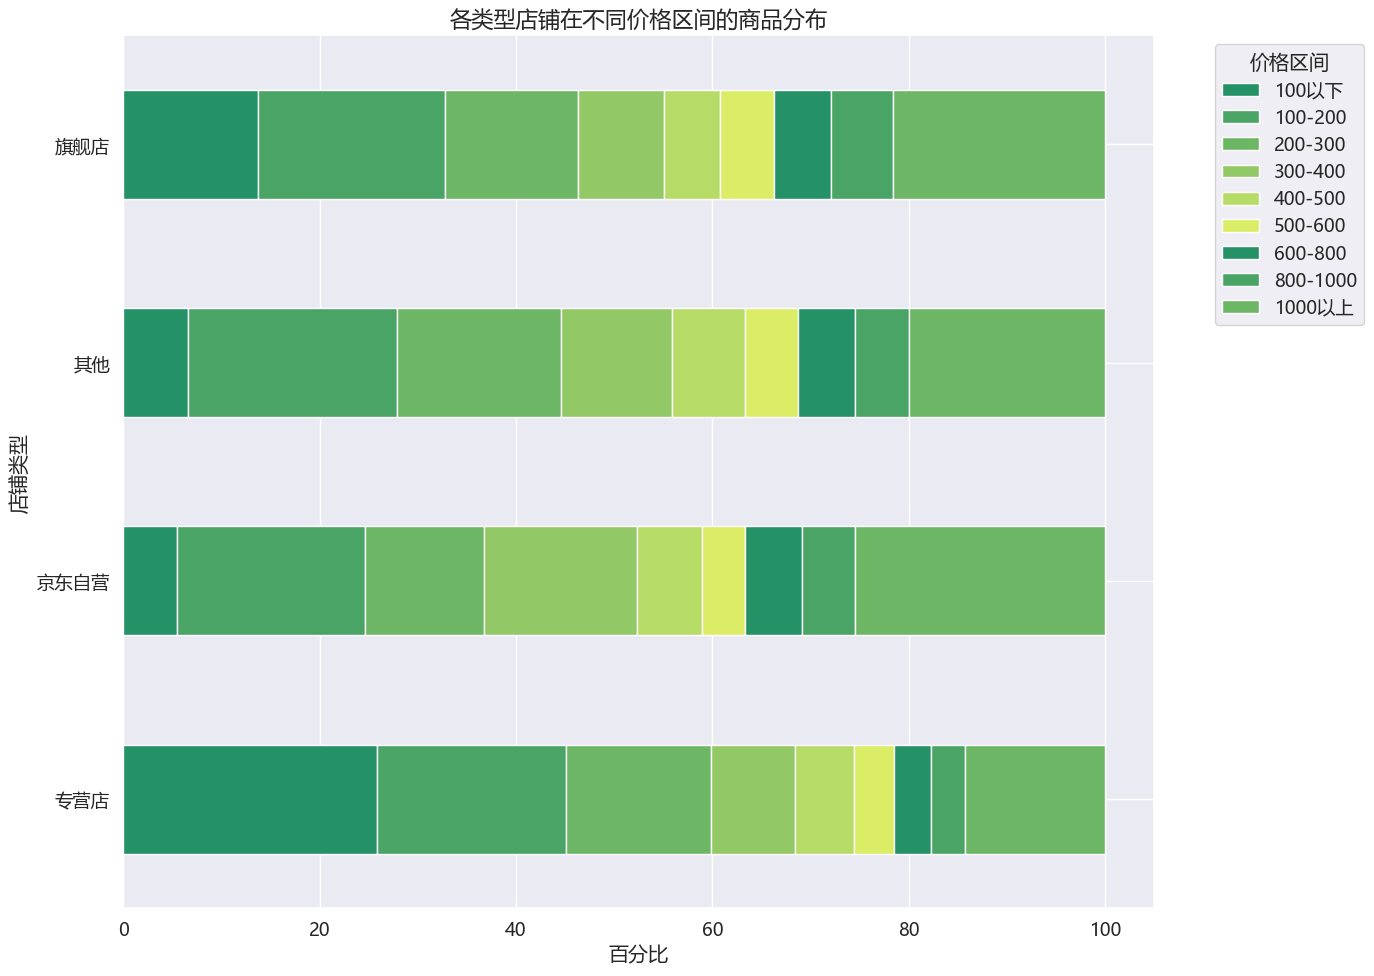

In [22]:
# 创建交叉表分析各类型店铺在不同价格区间的分布
cross_tab = pd.crosstab(df['shop_type'], df['price_range'], normalize='index') * 100

# 可视化
plt.figure(figsize=(14, 10))
cross_tab.plot(kind='barh', stacked=True, figsize=(14, 10))
plt.title('各类型店铺在不同价格区间的商品分布', fontsize=16)
plt.xlabel('百分比')
plt.ylabel('店铺类型')
plt.legend(title='价格区间', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 成交量分析

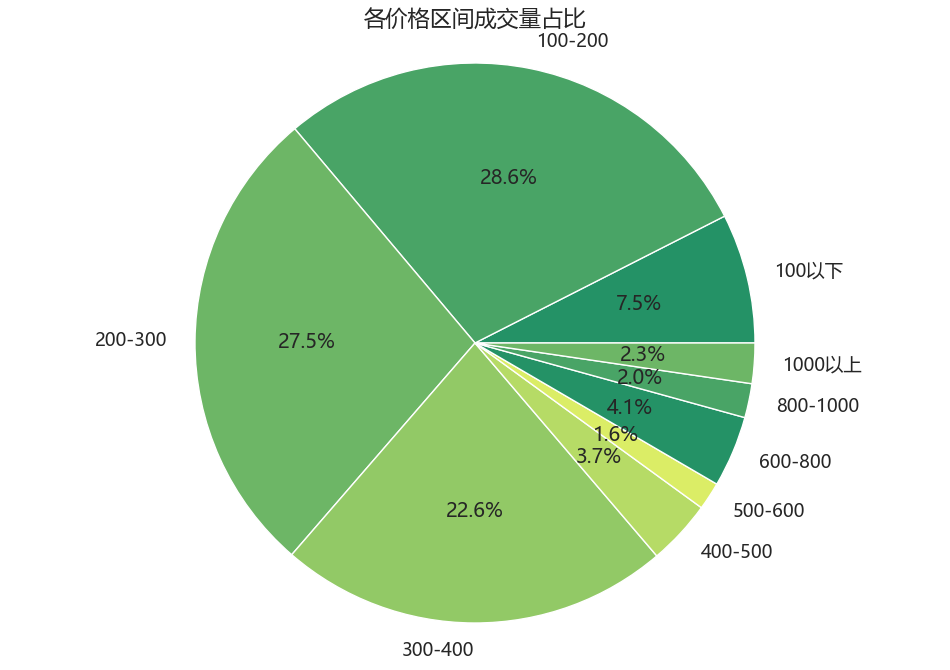

In [23]:
# 各价格区间成交量总和
price_comment = df.groupby('price_range')['new_comment'].sum()

plt.figure(figsize=(12, 8))
plt.pie(price_comment.values, labels=price_comment.index, autopct='%.1f%%')
plt.title('各价格区间成交量占比', fontsize=16)
plt.axis('equal')
plt.show()

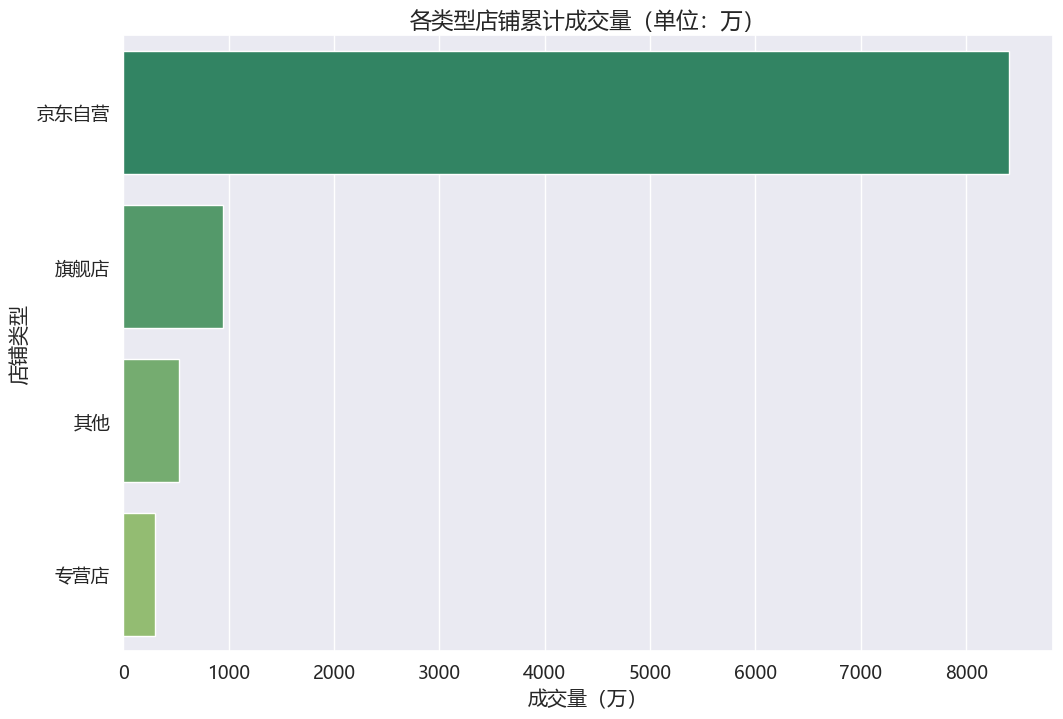

In [24]:
# 各类型店铺成交量
shop_comment = df.groupby('shop_type')['new_comment'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=shop_comment.values/10000, y=shop_comment.index)
plt.title('各类型店铺累计成交量（单位：万）', fontsize=16)
plt.xlabel('成交量（万）')
plt.ylabel('店铺类型')
plt.show()

# 分析结论
通过上述分析，我们得出以下主要结论：
1. 店铺分布​​：专营店和旗舰店在店铺数量上占主导地位，而京东自营店铺数量相对较少。
2. 商品分布​​：尽管京东自营店铺数量少，但其商品数量占比却较高，说明自营店铺的平均商品数量更多。
3. ​​价格分布​​：京东自营店铺在较高价格区间（如1000元以上）的商品占比较高，而其他类型店铺更多集中在低价区间。
4. ​​成交量分析​​：京东自营店铺以相对较少的商品数量获得了绝大部分的成交量，表明消费者对自营店铺的信任度和购买意愿更高。
5. ​​市场竞争​​：非自营类店铺（尤其是专营店）面临激烈的市场竞争，需要争夺剩余的有限市场份额。
